In [1]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

In [2]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving image5.webp to image5.webp


In [3]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving image3.jpeg to image3.jpeg


In [4]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2024-05-01 14:47:02--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  10.8MB/s    in 0.5s    

2024-05-01 14:47:03 (10.8 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [5]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (57/57), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.5 MB/s eta 0:00:00


In [6]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)

  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

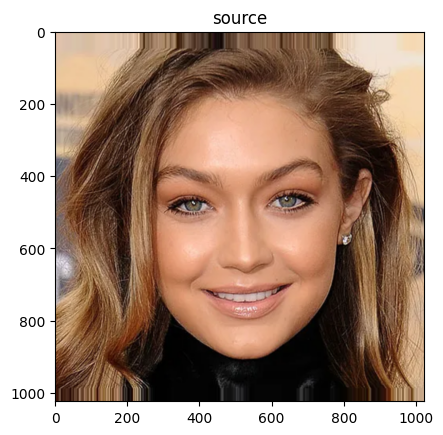

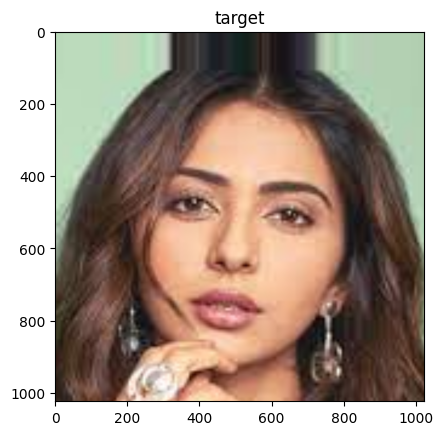

((384, 489), (642, 478))
((386, 490), (643, 522))


In [7]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

print(find_eyes(cropped_source))
print(find_eyes(cropped_target))

In [9]:

cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.56 loss 24567.23
step    2/1000: dist 0.69 loss 27640.66
step    3/1000: dist 0.60 loss 27166.72
step    4/1000: dist 0.63 loss 26253.43
step    5/1000: dist 0.64 loss 24957.25
step    6/1000: dist 0.58 loss 23352.12
step    7/1000: dist 0.57 loss 21510.73
step    8/1000: dist 0.53 loss 19486.80
step    9/1000: dist 0.63 loss 17341.57
step   10/1000: dist 0.57 loss 15140.35
step   11/1000: dist 0.51 loss 12947.02
step   12/1000: dist 0.57 loss 10818.13
step   13/1000: dist 0.55 loss 8801.26
step   14/1000: dist 0.55 loss 6946.59
step   15/1000: dist 0.53 loss 5313.83
step   16/1000: dist 0.54 loss 3971.63
step   17/1000: dist 0.57 loss 2942.58
step   18/1000: dist 0.53 loss 2210.97
step   19/1000: dist 0

In [13]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.62 loss 24567.29
step    2/1000: dist 0.65 loss 27640.63
step    3/1000: dist 0.65 loss 27166.76
step    4/1000: dist 0.65 loss 26253.45
step    5/1000: dist 0.66 loss 24957.27
step    6/1000: dist 0.66 loss 23352.20
step    7/1000: dist 0.64 loss 21510.79
step    8/1000: dist 0.60 loss 19486.87
step    9/1000: dist 0.65 loss 17341.59
step   10/1000: dist 0.60 loss 15140.39
step   11/1000: dist 0.58 loss 12947.09
step   12/1000: dist 0.58 loss 10818.15
step   13/1000: dist 0.60 loss 8801.31
step   14/1000: dist 0.54 loss 6946.58
step   15/1000: dist 0.53 loss 5313.84
step   16/1000: dist 0.54 loss 3971.63
step   17/1000: dist 0.56 loss 2942.56
step   18/1000: dist 0.56 loss 2211.00
step   19/1000: dist 0

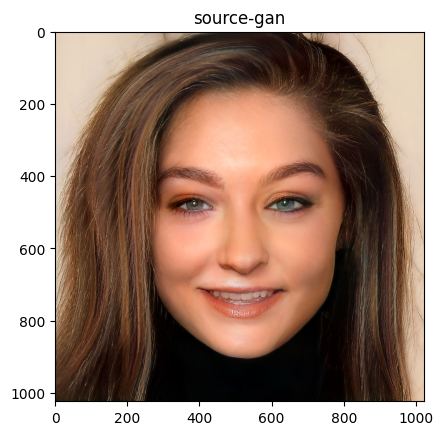

In [14]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

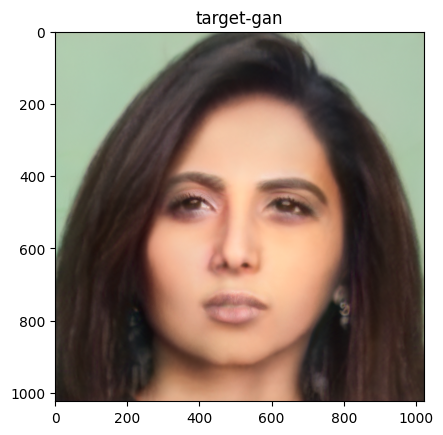

In [15]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

In [17]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

# Choose the interpolation factor (0.0 for lvec1, 1.0 for lvec2, 0.5 for midway)
alpha = 0.5
morphed_w = lvec1 * (1 - alpha) + lvec2 * alpha

# Generate the morphed image

z = torch.from_numpy(morphed_w).to(device)
z = z.view(-1, 18, 512)
synth_image = G.synthesis(z, noise_mode='const')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[0]

# Save the morphed image
output_image = PIL.Image.fromarray(synth_image, 'RGB')
output_image.save('/content/morphed_image.png')


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
